https://zhuanlan.zhihu.com/p/260703124

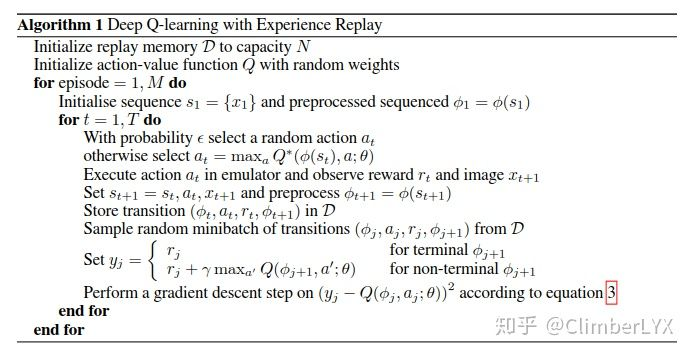

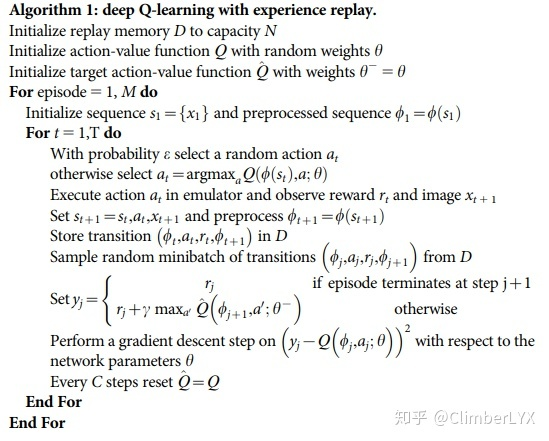

In [4]:
# 作者：ClimberLYX
# 链接：https://zhuanlan.zhihu.com/p/260703124
# 来源：知乎
# 著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。

import torch                                    # 导入torch
import torch.nn as nn                           # 导入torch.nn
import torch.nn.functional as F                 # 导入torch.nn.functional
import numpy as np                              # 导入numpy
import gym                                      # 导入gym

# 超参数
BATCH_SIZE = 32                                 # 样本数量
LR = 0.01                                       # 学习率
EPSILON = 0.9                                   # greedy policy
GAMMA = 0.9                                     # reward discount
TARGET_REPLACE_ITER = 100                       # 目标网络更新频率
MEMORY_CAPACITY = 2000                          # 记忆库容量
env = gym.make('CartPole-v0').unwrapped         # 使用gym库中的环境：CartPole，且打开封装(若想了解该环境，请自行百度)
N_ACTIONS = env.action_space.n                  # 杆子动作个数 (2个)
N_STATES = env.observation_space.shape[0]       # 杆子状态个数 (4个)


"""
torch.nn是专门为神经网络设计的模块化接口。nn构建于Autograd之上，可以用来定义和运行神经网络。
nn.Module是nn中十分重要的类，包含网络各层的定义及forward方法。
定义网络：
    需要继承nn.Module类，并实现forward方法。
    一般把网络中具有可学习参数的层放在构造函数__init__()中。
    只要在nn.Module的子类中定义了forward函数，backward函数就会被自动实现(利用Autograd)。
"""


# 定义Net类 (定义网络)
class Net(nn.Module):
    def __init__(self):                                                         # 定义Net的一系列属性
        # nn.Module的子类函数必须在构造函数中执行父类的构造函数
        super(Net, self).__init__()                                             # 等价与nn.Module.__init__()

        self.fc1 = nn.Linear(N_STATES, 50)                                      # 设置第一个全连接层(输入层到隐藏层): 状态数个神经元到50个神经元
        self.fc1.weight.data.normal_(0, 0.1)                                    # 权重初始化 (均值为0，方差为0.1的正态分布)
        self.out = nn.Linear(50, N_ACTIONS)                                     # 设置第二个全连接层(隐藏层到输出层): 50个神经元到动作数个神经元
        self.out.weight.data.normal_(0, 0.1)                                    # 权重初始化 (均值为0，方差为0.1的正态分布)

    def forward(self, x):                                                       # 定义forward函数 (x为状态)
        x = F.relu(self.fc1(x))                                                 # 连接输入层到隐藏层，且使用激励函数ReLU来处理经过隐藏层后的值
        actions_value = self.out(x)                                             # 连接隐藏层到输出层，获得最终的输出值 (即动作值)
        return actions_value                                                    # 返回动作值


# 定义DQN类 (定义两个网络)
class DQN(object):
    def __init__(self):                                                         # 定义DQN的一系列属性
        self.eval_net, self.target_net = Net(), Net()                           # 利用Net创建两个神经网络: 评估网络和目标网络
        self.learn_step_counter = 0                                             # for target updating
        self.memory_counter = 0                                                 # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))             # 初始化记忆库，一行代表一个transition
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)    # 使用Adam优化器 (输入为评估网络的参数和学习率)
        self.loss_func = nn.MSELoss()                                           # 使用均方损失函数 (loss(xi, yi)=(xi-yi)^2)

    def choose_action(self, x):                                                 # 定义动作选择函数 (x为状态)
        x = torch.unsqueeze(torch.FloatTensor(x), 0)                            # 将x转换成32-bit floating point形式，并在dim=0增加维数为1的维度
        if np.random.uniform() < EPSILON:                                       # 生成一个在[0, 1)内的随机数，如果小于EPSILON，选择最优动作
            actions_value = self.eval_net.forward(x)                            # 通过对评估网络输入状态x，前向传播获得动作值
            action = torch.max(actions_value, 1)[1].data.numpy()                # 输出每一行最大值的索引，并转化为numpy ndarray形式
            action = action[0]                                                  # 输出action的第一个数
        else:                                                                   # 随机选择动作
            action = np.random.randint(0, N_ACTIONS)                            # 这里action随机等于0或1 (N_ACTIONS = 2)
        return action                                                           # 返回选择的动作 (0或1)

    def store_transition(self, s, a, r, s_):                                    # 定义记忆存储函数 (这里输入为一个transition)
        transition = np.hstack((s, [a, r], s_))                                 # 在水平方向上拼接数组
        # 如果记忆库满了，便覆盖旧的数据
        index = self.memory_counter % MEMORY_CAPACITY                           # 获取transition要置入的行数
        self.memory[index, :] = transition                                      # 置入transition
        self.memory_counter += 1                                                # memory_counter自加1

    def learn(self):                                                            # 定义学习函数(记忆库已满后便开始学习)
        # 目标网络参数更新
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:                  # 一开始触发，然后每100步触发
            self.target_net.load_state_dict(self.eval_net.state_dict())         # 将评估网络的参数赋给目标网络
        self.learn_step_counter += 1                                            # 学习步数自加1

        # 抽取记忆库中的批数据
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)            # 在[0, 2000)内随机抽取32个数，可能会重复
        b_memory = self.memory[sample_index, :]                                 # 抽取32个索引对应的32个transition，存入b_memory
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        # 将32个s抽出，转为32-bit floating point形式，并存储到b_s中，b_s为32行4列
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        # 将32个a抽出，转为64-bit integer (signed)形式，并存储到b_a中 (之所以为LongTensor类型，是为了方便后面torch.gather的使用)，b_a为32行1列
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        # 将32个r抽出，转为32-bit floating point形式，并存储到b_s中，b_r为32行1列
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])
        # 将32个s_抽出，转为32-bit floating point形式，并存储到b_s中，b_s_为32行4列

        # 获取32个transition的评估值和目标值，并利用损失函数和优化器进行评估网络参数更新
        q_eval = self.eval_net(b_s).gather(1, b_a)
        # eval_net(b_s)通过评估网络输出32行每个b_s对应的一系列动作值，然后.gather(1, b_a)代表对每行对应索引b_a的Q值提取进行聚合
        q_next = self.target_net(b_s_).detach()
        # q_next不进行反向传递误差，所以detach；q_next表示通过目标网络输出32行每个b_s_对应的一系列动作值
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)
        # q_next.max(1)[0]表示只返回每一行的最大值，不返回索引(长度为32的一维张量)；.view()表示把前面所得到的一维张量变成(BATCH_SIZE, 1)的形状；最终通过公式得到目标值
        loss = self.loss_func(q_eval, q_target)
        # 输入32个评估值和32个目标值，使用均方损失函数
        self.optimizer.zero_grad()                                      # 清空上一步的残余更新参数值
        loss.backward()                                                 # 误差反向传播, 计算参数更新值
        self.optimizer.step()                                           # 更新评估网络的所有参数


dqn = DQN()                                                             # 令dqn=DQN类

for i in range(400):                                                    # 400个episode循环
    print('<<<<<<<<<Episode: %s' % i)
    s = env.reset()                                                     # 重置环境
    episode_reward_sum = 0                                              # 初始化该循环对应的episode的总奖励

    while True:                                                         # 开始一个episode (每一个循环代表一步)
        env.render()                                                    # 显示实验动画
        a = dqn.choose_action(s)                                        # 输入该步对应的状态s，选择动作
        s_, r, done, info = env.step(a)                                 # 执行动作，获得反馈

        # 修改奖励 (不修改也可以，修改奖励只是为了更快地得到训练好的摆杆)
        x, x_dot, theta, theta_dot = s_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        new_r = r1 + r2

        dqn.store_transition(s, a, new_r, s_)                 # 存储样本
        episode_reward_sum += new_r                           # 逐步加上一个episode内每个step的reward

        s = s_                                                # 更新状态

        if dqn.memory_counter > MEMORY_CAPACITY:              # 如果累计的transition数量超过了记忆库的固定容量2000
            # 开始学习 (抽取记忆，即32个transition，并对评估网络参数进行更新，并在开始学习后每隔100次将评估网络的参数赋给目标网络)
            dqn.learn()

        if done:       # 如果done为True
            # round()方法返回episode_reward_sum的小数点四舍五入到2个数字
            print('episode%s---reward_sum: %s' % (i, round(episode_reward_sum, 2)))
            break                                             # 该episode结束

/Users/minkexiu/opt/anaconda3/lib/python3.9/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


<<<<<<<<<Episode: 0
episode0---reward_sum: 5.03
<<<<<<<<<Episode: 1
episode1---reward_sum: 11.33
<<<<<<<<<Episode: 2
episode2---reward_sum: 5.59
<<<<<<<<<Episode: 3
episode3---reward_sum: 6.53
<<<<<<<<<Episode: 4
episode4---reward_sum: 7.11
<<<<<<<<<Episode: 5
episode5---reward_sum: 8.71
<<<<<<<<<Episode: 6
episode6---reward_sum: 8.61
<<<<<<<<<Episode: 7
episode7---reward_sum: 3.38
<<<<<<<<<Episode: 8
episode8---reward_sum: 2.15
<<<<<<<<<Episode: 9
episode9---reward_sum: 2.52
<<<<<<<<<Episode: 10
episode10---reward_sum: 1.52
<<<<<<<<<Episode: 11
episode11---reward_sum: 4.33
<<<<<<<<<Episode: 12
episode12---reward_sum: 4.85
<<<<<<<<<Episode: 13
episode13---reward_sum: 10.04
<<<<<<<<<Episode: 14
episode14---reward_sum: 3.07
<<<<<<<<<Episode: 15
episode15---reward_sum: 2.46
<<<<<<<<<Episode: 16
episode16---reward_sum: 4.11
<<<<<<<<<Episode: 17
episode17---reward_sum: 4.55
<<<<<<<<<Episode: 18
episode18---reward_sum: 7.97
<<<<<<<<<Episode: 19
episode19---reward_sum: 2.65
<<<<<<<<<Episode: 

episode160---reward_sum: 276.1
<<<<<<<<<Episode: 161
episode161---reward_sum: 247.81
<<<<<<<<<Episode: 162
episode162---reward_sum: 260.26
<<<<<<<<<Episode: 163
episode163---reward_sum: 148.55
<<<<<<<<<Episode: 164
episode164---reward_sum: 804.06
<<<<<<<<<Episode: 165
episode165---reward_sum: 331.38
<<<<<<<<<Episode: 166
episode166---reward_sum: 272.52
<<<<<<<<<Episode: 167
episode167---reward_sum: 235.46
<<<<<<<<<Episode: 168
episode168---reward_sum: 229.55
<<<<<<<<<Episode: 169
episode169---reward_sum: 1613.92
<<<<<<<<<Episode: 170
episode170---reward_sum: 555.42
<<<<<<<<<Episode: 171
episode171---reward_sum: 146.31
<<<<<<<<<Episode: 172
episode172---reward_sum: 163.0
<<<<<<<<<Episode: 173
episode173---reward_sum: 885.35
<<<<<<<<<Episode: 174
episode174---reward_sum: 480.73
<<<<<<<<<Episode: 175
episode175---reward_sum: 373.34
<<<<<<<<<Episode: 176
episode176---reward_sum: 1161.51
<<<<<<<<<Episode: 177
episode177---reward_sum: 929.22
<<<<<<<<<Episode: 178
episode178---reward_sum: 226

KeyboardInterrupt: 

In [11]:
import tqdm, time
for i in tqdm.tqdm(range(1800)):
    time.sleep(1)

  0%|▏                                         | 9/1800 [00:09<32:10,  1.08s/it]


KeyboardInterrupt: 